In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
# from sklearn.decomposition import FastICA
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.model_selection import cross_val_score
# from itertools import combinations
# from sklearn.preprocessing import normalize
# from sklearn.utils import shuffle
import pickle

from multiprocessing import Pool
plt.style.use('seaborn-whitegrid')

# GroudTruth

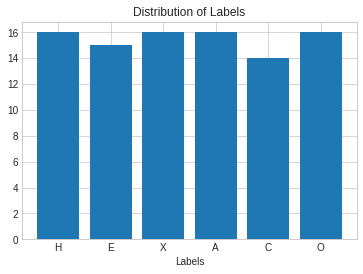

In [2]:
gt = load_groudtruth('./HEXACO.csv')
fig, ax = plt.subplots()
ax.bar(['H','E','X','A','C','O'],[ sum(gt['lh']), sum(gt['le']), sum(gt['lx']), sum(gt['la']), sum(gt['lc']), sum(gt['lo'])  ])
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

# Load DATA

In [3]:
# clear_cache()
try:
    # Load from cache
    EEG_audio = load('EEG_audio')
    EEG_image = load('EEG_image')
    print('Load data from cache')
    if( set(EEG_audio.keys()) != set(EEG_image.keys()) ):
        extra = None
        if(len(EEG_audio.keys()) > len(EEG_image.keys())):
            extra = set(EEG_audio.keys()).difference( set(EEG_image.keys()) )
        else:
            extra = set(EEG_image.keys()).difference( set(EEG_audio.keys()) )
        raise ValueError(f"In equal keys. audio has {len(EEG_audio.keys())} and image has {len(EEG_image.keys())}. The extra key is {extra}")

except FileNotFoundError as e:
    EEG_audio, EEG_image = load_data(path='./data',exclude_list=[11,36])
    # Save to cache
    save(EEG_audio, 'EEG_audio')
    save(EEG_image, 'EEG_image')


Load data from cache


# Generic Head Model

In [103]:
def get_head_model():
    import os.path as op
    import numpy as np

    import mne
    from mne.datasets import eegbci
    from mne.datasets import fetch_fsaverage

    # Download fsaverage files
    fs_dir = fetch_fsaverage(verbose=True)
    subjects_dir = op.dirname(fs_dir)

    # The files live in:
    subject = 'fsaverage'
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
    bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
    return trans, src, bem

def get_forward(info):

    trans, src, bem = get_head_model()
    fwd = mne.make_forward_solution(info, trans=trans, src=src,
                                bem=bem, eeg=True, mindist=5.0, n_jobs=1)
    return fwd

def get_raw(df,sfreq):
    raw = dataframe_to_raw(df, sfreq=sfreq)
    #### Preprocess
    # High-pass at 0.1 Hz with  FIR filter; zero phase; Hamming Window; Auto select length and Bandwidth
    raw.filter(l_freq=0.1,h_freq=None,method='fir',phase='zero',fir_window='hamming') # Slow drift
    # Notch Filter at 50,100,150,200 Hz with FIR filter; zero phase; Hamming Window, Bandwidth = 0.1; auto length selection
    raw.notch_filter(freqs=[50],method='fir', phase='zero', fir_window='hamming',trans_bandwidth=0.1, filter_length='auto') # Line power
    return raw

In [104]:
# mne.set_config('SUBJECTS_DIR','/home/akrarads/mne_data/MNE-fsaverage-data')
# mne.get_config()

#### Just get fwd ####
with get_raw(df=EEG_image[33],sfreq=250) as raw:
    fwd = get_forward(raw.info)

0 files missing from root.txt in /home/akrarads/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/akrarads/mne_data/MNE-fsaverage-data/fsaverage
Source space          : /home/akrarads/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /home/akrarads/venv/hci/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /home/akrarads/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /home/akrarads/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.00000

# Processing

In [59]:
verbose = False

In [109]:
raw = dataframe_to_raw(EEG_image[33], sfreq=250)
#### Preprocess
# High-pass at 0.1 Hz with  FIR filter; zero phase; Hamming Window; Auto select length and Bandwidth
raw.filter(l_freq=0.1,h_freq=None,method='fir',phase='zero',fir_window='hamming', verbose=verbose) # Slow drift
# Notch Filter at 50,100,150,200 Hz with FIR filter; zero phase; Hamming Window, Bandwidth = 0.1; auto length selection
raw.notch_filter(freqs=[50],method='fir', phase='zero', fir_window='hamming',trans_bandwidth=0.1, filter_length='auto', verbose=verbose) # Line power

events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=verbose, uint_cast=False)
events_dict = dict({
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
})
for row in events:
    row[2] = int(str(row[2])[0])
    events_dict[row[2]].append(row)


In [110]:
epochs_dict = dict()
epochs_dict['all'] = mne.Epochs(raw, events, tmin=0, tmax=6, baseline=(0,1), verbose=verbose, preload=True)
for cat in range(1,6): #1 -> 5
    epochs_dict[cat] = mne.Epochs(raw, events_dict[cat], tmin=0, tmax=6, baseline=(0,1), verbose=verbose, preload=True)

In [119]:
# f = epochs_1.average().plot()
# f = epochs_2.average().plot()
# f = epochs_3.average().plot()
# f = epochs_4.average().plot()
# f = epochs_5.average().plot()
cov = mne.compute_covariance(epochs_dict['all'], method='auto')
print('='*20)
inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, loose=1, depth=0.1)

Computing rank from data with rank=None
    Using tolerance 2.8e-11 (2.2e-16 eps * 8 dim * 1.6e+04  max singular value)
    Estimated rank (eeg): 8
    EEG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 88559
log-likelihood on unseen data (descending order):
   shrunk: -33.283
   empirical: -33.359
   diagonal_fixed: -33.396
selecting best estimator: shrunk
[done]
Computing inverse operator with 8 channels.
    8 out of 8 channels remain after picking
Selected 8 channels
Creating the depth weighting matrix...
    8 EEG channels
    limit = 20485/20484 = 3.432080
    scale = 14529.9 exp = 0.1
Whitening the forward solution.
C

<ipython-input-119-c0f9ffc9ab5c>:8: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, loose=1, depth=0.1)
<ipython-input-119-c0f9ffc9ab5c>:8: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, loose=1, depth=0.1)
